# Programming Project #2: Image Quilting

## CS445: Computational Photography


https://github.com/jmecom/image-quilting/blob/master/quilting.m

In [176]:
# from google.colab import drive
# drive.mount('/content/drive')

In [177]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "./"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: './utils.py' and './utils.py' are the same file
cp: './samples' and './samples' are the same file


In [178]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [179]:
import numpy as np
import random

def quilt_random(sample_img, out_size, patch_size):
    height, width, _ = sample_img.shape
    black_image = np.zeros((out_size, out_size, 3), dtype=np.uint8)

    # keeping track of the current place we are in the black image
    current_x = 0
    current_y = 0

    # the farthest we can go on the x or y axis
    stopping_depth = out_size - patch_size

    # while we are not at the bottom of the image (this is most important as we dynamically will check and update our current_x)
    while current_y <= stopping_depth:
        # Check if we can still fit a patch horizontally
        if current_x <= stopping_depth:  
            # First, we want to get the random sample
            start_x = random.randint(0, width - patch_size)
            start_y = random.randint(0, height - patch_size)

            # Extract the patch from the sample image
            current_sample = sample_img[start_y:start_y + patch_size, start_x:start_x + patch_size]

            # Place the sample in the black image
            black_image[current_y:current_y + patch_size, current_x:current_x + patch_size] = current_sample

            # Move current_x to the right. We know we can do this because we checked to ensure we are not at the stopping depth
            current_x += patch_size
        else:
            # Move to the next row if we've reached the edge of the current row
            current_x = 0
            current_y += patch_size

    return black_image

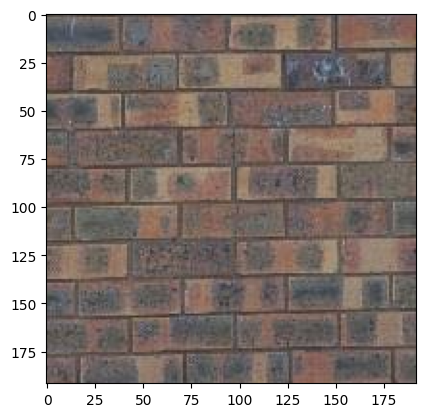

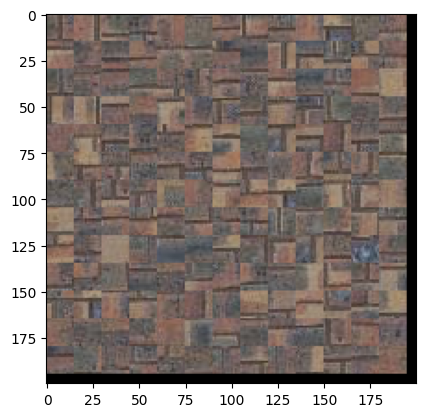

In [180]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

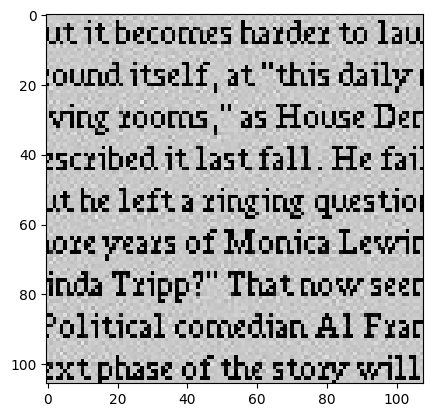

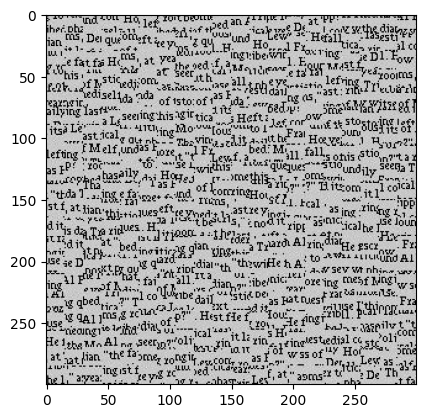

In [181]:
sample_img_fn = 'samples/text_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

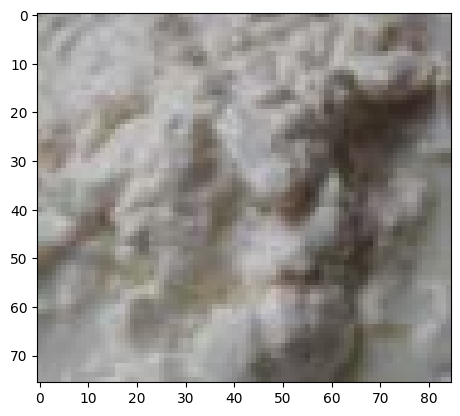

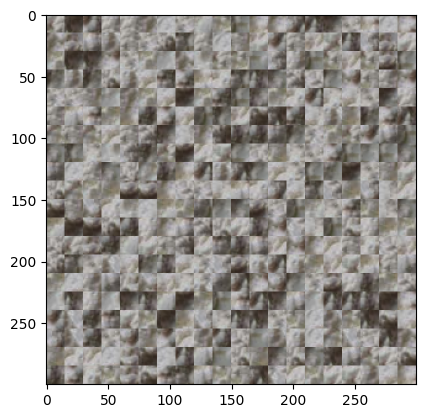

In [182]:
sample_img_fn = 'samples/white_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [183]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

def quilt_simple(sample_img, out_size, patch_size, overlap, tol):

    # first, we generate the masks for the area to the left that will be overlapping, the area to the right, and the area above. We don't need to do 
    # anything for below because we will be filling from top left to bottom right, row by row. These masks will always be the same, because we are
    # not dynamically changing the size of these masks or way they look. The overlap will always be the same depending on where the sample we are placing is

    # 3 different scenarios in which we see overlap..
    top_mask = np.zeros((patch_size, patch_size, 3))
    left_mask = np.zeros((patch_size, patch_size, 3))
    both_mask = np.zeros((patch_size, patch_size, 3))

    top_mask[:overlap, :, :] = 1 # 1's where we see an overlap
    left_mask[:,:overlap,:] = 1 
    both_mask[:, :overlap, :] = 1
    both_mask[:overlap, :, :] = 1

    # now we define an output image. By default it will be black everywhere until we start to fill it in
    black_image = np.zeros((out_size, out_size, 3))
    rows = (out_size-overlap) // (patch_size-overlap) # we can define the number of iterations in rows we get by dividing out size - overlap by patch 
                                                      # size - overlap. Specifically, we do the numerator like that to ensure that the last patch will 
                                                      # fit, and the denominator because that is the total number of patches will will want to see fit 
                                                      # into the width of the output black_image
    
    cols = (out_size-overlap) // (patch_size-overlap) # same idea for the columns 
        

    # finally, fill in the rest of the image using both_mask
    for i in range(0,cols): 
        for j in range(0,rows):
            
            # if this is true, we know we are dealing with the top left corner. We want to randomly sample that
            if i + j == 0:
                rand_row = random.randint(0, sample_img.shape[0]-patch_size)
                rand_col = random.randint(0, sample_img.shape[1]-patch_size)
                # and place it in the top left hand corner
                black_image[:patch_size, :patch_size, :] = sample_img[rand_row:rand_row+patch_size, rand_col:rand_col+patch_size, :].copy()
                
            # if this is true, we are dealing with values in the first column. I provided comments here as the process is the same for other two
            # filters
            elif j == 0:
                T = black_image[i * (patch_size - overlap):i * (patch_size - overlap) + patch_size, :patch_size, :] # area we want to fill
                                                                                                                    # in x coordinates, this is multiplying whatever row our loop is on to get
                                                                                                                    # to point in the image we want to get to (from that point to that point +
                                                                                                                    # patch size.. For y coordinates, we go from 0 to patch size, as we know
                                                                                                                    # we are just on the first row so we can start from 0. the 3rd dimension we do
                                                                                                                    # everything. 
                M = top_mask
                I = sample_img
        
                ssd = ssd_patch(T, M, I) # returns costs across the whole image of taking a sample at that pixel, compared to area we are currently trying to fill
                h, w = ssd.shape                                                                                                                           
                ssd = ssd[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2] # we need to ensure that our ssd only lets us choose a sample from values that are within a 
                                                                                            # patch_size of the edge. If a pixel is chosen that is technically the best, but is on the edge, 
                                                                                            # we will get an error when we try to use it as it will not have enough pixels around it to be a 
                                                                                            # full patch
        
                # why do we divide each value by 2? It is because we care most about the center of the ssd. Since the ssd returns costs for sampling each pixel, not only do we want to 
                # ensure we are able to sample a low cost pixel that can fit a whole patch, but we want to go even further to the center, because we want a pixel that has a low cost but is
                # also relevant in that it matches the center of the matching area
                
                (row, col) = choose_sample(ssd, tol) # returns the index of the pixel that we have chosen to select 
        
                black_image[i * (patch_size - overlap):i * (patch_size - overlap) + patch_size, :patch_size, :] = sample_img[row:row+patch_size, col:col+patch_size,:].copy()

            # if this true, we are in the first row..
            elif i == 0:
                T = black_image[:patch_size,j * (patch_size - overlap):j * (patch_size - overlap) + patch_size , :] 
                M = left_mask
                I = sample_img
        
                ssd = ssd_patch(T, M, I) 
                
                h, w = ssd.shape                                                                                                                           
                ssd = ssd[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2] 
        
                (row, col) = choose_sample(ssd, tol)
        
                black_image[:patch_size, j * (patch_size - overlap):j * (patch_size - overlap) + patch_size, :] = sample_img[row:row+patch_size, col:col+patch_size,:].copy()

            # and finally, if we get here then that means that we are in the main portion of the image and need to use the both filter
            else:
                T = black_image[i * (patch_size - overlap):i * (patch_size - overlap) + patch_size,j * (patch_size - overlap):j * (patch_size - overlap) + patch_size, :] 
                M = both_mask
                I = sample_img
        
                ssd = ssd_patch(T, M, I) 
                
                h, w = ssd.shape                                                                                                                           
                ssd = ssd[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2] 
        
                (row, col) = choose_sample(ssd, tol)
        
                black_image[i * (patch_size - overlap):i * (patch_size - overlap) + patch_size, j * (patch_size - overlap):j * (patch_size - overlap) + patch_size, :] \
                                                                                                            = sample_img[row:row+patch_size, col:col+patch_size,:].copy()

    return black_image

In [184]:
def ssd_patch(T, M, I):

    """

    performs template matching with the overlapping region, computing the cost of sampling each patch, based on the sum of squared differences (SSD) of the overlapping regions of the
    existing and sampled patch. I suggest using a masked template. The template is the patch in the current output image that is to be filled in (many pixel values will be 0 because
    they are not filled in yet). The mask has the same size as the patch template and has values of 1 in the overlapping region and values of 0 elsewhere. The SSD of the masked 
    template with the input texture image can be computed efficiently using filtering operations. Suppose I have a template T, a mask M, and an image I: then, ssd_cost = ((M*T)**2).
    sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M). You can compute SSD in this way for each channel and sum the costs over 
    channels. Each pixel of the ssd_cost gives you the cost for sampling a patch centered around that pixel.
    
    """
    # just in case to avoid errors, convert to to floats
    T = T.astype(np.float64) # area we want to fill
    M = M.astype(np.float64) # mask (pre-defined)
    I = I.astype(np.float64) # whole sample_image

    # We need to scale the values of our temlate and input image.. if this is not done, we will have much larger values and therefore less consistency 
    T = T / 50
    I = I / 50

    # ssd_cost = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    # I am not sure how this really works or how it was derived in relation to what one would normally think of as a SSD computation. I just know it is a more efficient way of 
    # calculating the SSD for larger images, and it was provided in the instructions

    # need to do this for each channel of color (the (, ,3) value seen in our matrices..)
    r = ((M[:,:,0]*T[:,:,0])**2).sum() - 2 * cv2.filter2D(I[:,:,0], ddepth=-1, kernel = M[:,:,0]*T[:,:,0]) \
                                                        + cv2.filter2D(I[:,:,0] ** 2, ddepth=-1, kernel=M[:,:,0]) # R
    g = ((M[:,:,1]*T[:,:,1])**2).sum() - 2 * cv2.filter2D(I[:,:,1], ddepth=-1, kernel = M[:,:,1]*T[:,:,1]) \
                                                        + cv2.filter2D(I[:,:,1] ** 2, ddepth=-1, kernel=M[:,:,1]) # G
    b = ((M[:,:,2]*T[:,:,2])**2).sum() - 2 * cv2.filter2D(I[:,:,2], ddepth=-1, kernel = M[:,:,2]*T[:,:,2]) \
                                                        + cv2.filter2D(I[:,:,2] ** 2, ddepth=-1, kernel=M[:,:,2]) # B

    # print(r.shape,g.shape,b.shape)

    # get rows and columns of the output ssd from one of the channels
    (rows, cols) = r.shape

    ssd = np.zeros((rows, cols))
    ssd[:,:] = r + g + b # "...and sum the costs over channels"

    # key idea: since we convoluted over the entire input image, we now have the cost of taking out patch using each pixel as the center. Thus, the result is in the same 
    # shape as the actual sample_img 
    
    return np.absolute(ssd[:,:])

In [185]:
def choose_sample(cost, tol):
    """
    
    should take as input a cost image (each pixel's value is the cost of selecting the patch centered at that pixel) and select a randomly sampled patch with low cost. It's 
    recommended to sort the costs and choose of of the tol smallest costs. So if tol=1, the lowest cost will always be chosen (this is a good way to debug but mainly copies the input
    texture). If tol=3, one of the three lowest cost patches will be chosen. After a patch is sampled, its pixels should be copied directly into the corresponding position in the 
    output image. Note that it is very easy to make alignment mistakes when computing the cost of each patch, sampling a low-cost patch, and copying the patch from the source to the 
    output. Use an odd value for patch_size so that its center is well-defined. Be sure to thoroughly debug, for example, by checking that the overlapping portion of the copied pixels 
    has the same SSD as the originally computed cost. As a sanity check, try generating a small texture image with tol=1, with the first patch sampled from the upper-left of the 
    source image. This should produce a partial copy of the source image. Once you have this function working, save a result (with higher tolerance for more stochastic texture) 
    generated from the same sample as used for the random method.

    """
    flat_cost = cost.flatten()
    
    top_n_indices = np.argsort(flat_cost)[:tol]
    
    row, col = np.unravel_index(top_n_indices, cost.shape)
    
    index = list(zip(row, col))
    
    # Randomly select one from the top n indices
    return random.choice(index)

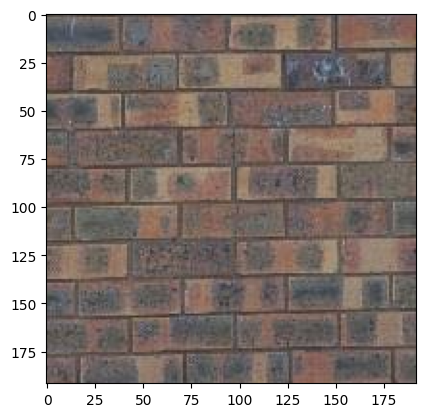

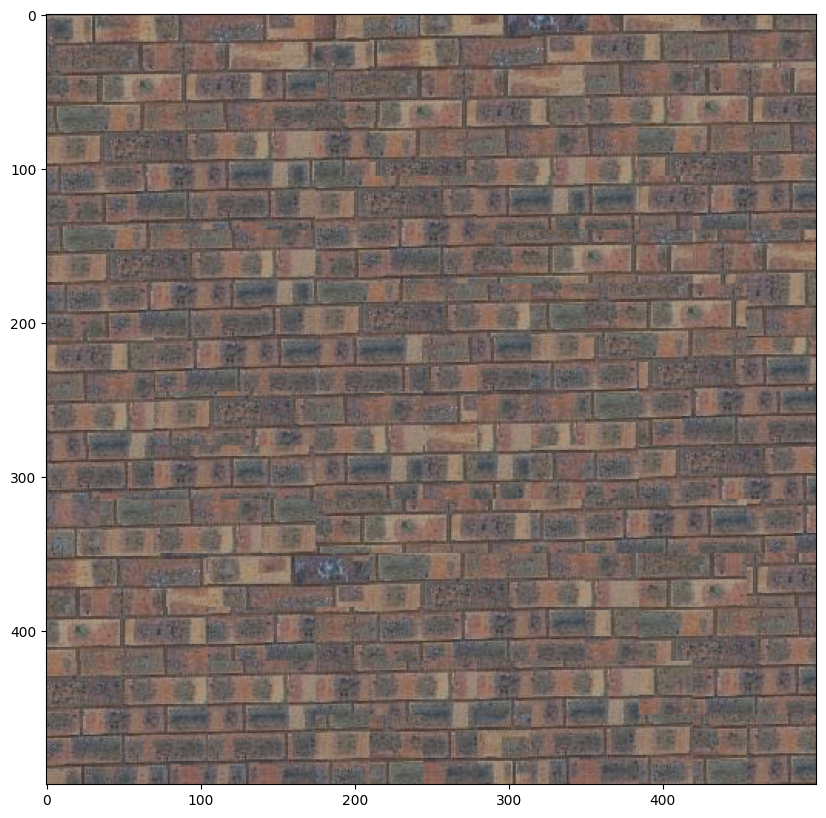

In [186]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 500  # change these parameters as needed
patch_size = 45
overlap = 10
tol = 3
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
res = res.astype(np.uint8)
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


https://devashi-choudhary.medium.com/texture-synthesis-generating-arbitrarily-large-textures-from-image-patches-32dd49e2d637

In [235]:
import numpy as np
import random

val = 10

def quilt_cut(sample_img, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    # we can do almost the same idea as the simple quilt here, but with the key difference being that we are going to use the
    # supplied cut function to find a pasth of least cost through the overlap. Using this to generate a mask, we can get the
    # pixels from each side of the seam (from T and from the new patch) that should be taken in order to keep the cost the 
    # lowest, and therefore look more seamless
    
    top_mask = np.zeros((patch_size, patch_size, 3))
    left_mask = np.zeros((patch_size, patch_size, 3))
    both_mask = np.zeros((patch_size, patch_size, 3))

    top_mask[:overlap, :, :] = 1 
    left_mask[:,:overlap,:] = 1 
    both_mask[:, :overlap, :] = 1
    both_mask[:overlap, :, :] = 1

    black_image = np.zeros((out_size, out_size, 3))
    
    rows = (out_size-overlap) // (patch_size-overlap) 
    cols = (out_size-overlap) // (patch_size-overlap) 

    for i in range(0, cols):
        for j in range(0, rows):
            if i + j == 0:
                rand_row = random.randint(0, sample_img.shape[0]-patch_size)
                rand_col = random.randint(0, sample_img.shape[1]-patch_size)
                black_image[:patch_size, :patch_size, :] = sample_img[rand_row:rand_row+patch_size, rand_col:rand_col+patch_size, :].copy()
            elif j == 0:
                T = black_image[i * (patch_size - overlap):i * (patch_size - overlap) + patch_size, :patch_size, :] 
                M = top_mask
                I = sample_img
        
                ssd = ssd_patch(T, M, I) 
                h, w = ssd.shape                                                                                                                           
                ssd = ssd[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2] 
            
                (row, col) = choose_sample(ssd, tol) 
        
                new = sample_img[row:row+patch_size, col:col+patch_size,:].copy()
                
                # Compute the cost of the overlapping region
                overlapped_region = T[:overlap, :patch_size, :]**2 - new[:overlap, :patch_size, :]**2 # what the cut function gets performed on is the region that our area to fill, and our new patch are overlappig on. It needs a difference matrix
                                                                                                      # of their squared values such that it can find the path for which the cost of cutting through is the least.
                
                overlapped_region = overlapped_region[:,:,0] + overlapped_region[:,:,1] + overlapped_region[:,:,2]  # this just sums the values across all color channels.
                
                mask_path = cut(overlapped_region) # this then returns a mask based off the path that incurs the least cost. We can use this mask to get the values that should come from T, and the values that should come from new based on the seam
                mask_path = mask_path.astype(np.uint8) 
        
                # even though we already generated new (the new patch), we now need to alter it based on this mask
                new[:overlap, :patch_size, 0] *= mask_path # multiplying the values in this color channel by the mask will keep values that should be kept on each side of the seam
                new[:overlap, :patch_size, 1] *= mask_path
                new[:overlap, :patch_size, 2] *= mask_path
        
                # we then use the inverse of the mask that was generated in order to get the values we will keep
                inv_mask = np.ones(mask_path.shape) - mask_path
                T[:overlap, :patch_size, 0] *= inv_mask
                T[:overlap, :patch_size, 1] *= inv_mask
                T[:overlap, :patch_size, 2] *= inv_mask
        
                # adding these two together will output the blended patch after our masks have been applied
                T += new
            elif i == 0:
                T = black_image[:patch_size,j * (patch_size - overlap):j * (patch_size - overlap) + patch_size, :] 
                M = left_mask
                I = sample_img
        
                ssd = ssd_patch(T, M, I) 
                h, w = ssd.shape                                                                                                                           
                ssd = ssd[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2] 
            
                (row, col) = choose_sample(ssd, tol) 
        
                new = sample_img[row:row+patch_size, col:col+patch_size,:].copy()
                
                overlapped_region = T[:patch_size,:overlap, :]**2 - new[:patch_size,:overlap, :]**2
                overlapped_region = overlapped_region[:,:,0] + overlapped_region[:,:,1] + overlapped_region[:,:,2]
                
                mask_path = cut(overlapped_region)
                mask_path = mask_path.astype(np.uint8)
        
                new[:patch_size,:overlap, 0] *= mask_path
                new[:patch_size,:overlap, 1] *= mask_path
                new[:patch_size,:overlap, 2] *= mask_path
        
                inv_mask = np.ones(mask_path.shape) - mask_path
                T[:patch_size,:overlap, 0] *= inv_mask
                T[:patch_size,:overlap, 1] *= inv_mask
                T[:patch_size,:overlap, 2] *= inv_mask
        
                T += new 

            else:
                T = black_image[i * (patch_size - overlap):i * (patch_size - overlap) + patch_size,j * (patch_size - overlap):j * (patch_size - overlap) + patch_size, :] 
                M = both_mask
                I = sample_img
            
                ssd = ssd_patch(T, M, I) 
                h, w = ssd.shape                                                                                                                           
                ssd = ssd[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2] 
            
                (row, col) = choose_sample(ssd, tol) 
            
                new = sample_img[row:row+patch_size, col:col+patch_size,:].copy()
    
                # the only slight difference that we do here is that we have to combine the masks we get from above and to the side, as this is the section using the both filter
                
                overlapped_region_above = T[:overlap, :patch_size, :]**2 - new[:overlap, :patch_size, :]**2
                overlapped_region_above = overlapped_region_above[:,:,0] + overlapped_region_above[:,:,1] + overlapped_region_above[:,:,2]
                
                overlapped_region_side = T[:patch_size,:overlap, :]**2 - new[:patch_size,:overlap, :]**2
                overlapped_region_side = overlapped_region_side[:,:,0] + overlapped_region_side[:,:,1] + overlapped_region_side[:,:,2]
                
                mask_path_above = cut(overlapped_region_above)
                mask_path_side = cut(overlapped_region_side)
    
                mask_path = np.ones((patch_size, patch_size))
                mask_path[:overlap, :patch_size] *= mask_path_above
                mask_path[:patch_size, :overlap] *= mask_path_side
                mask_path = mask_path.astype(np.uint8)
            
                new[:,:, 0] *= mask_path
                new[:,:, 1] *= mask_path
                new[:,:, 2] *= mask_path
                
                inv_mask = np.ones(mask_path.shape) - mask_path
                T[:,:, 0] *= inv_mask
                T[:,:, 1] *= inv_mask
                T[:,:, 2] *= inv_mask
            
                T += new
    
                if i == val and j == val:
                    plt.figure()
                    plt.imshow(overlapped_region_above)
                    
                    plt.figure()
                    plt.imshow(overlapped_region_side)
    
                    plt.figure()
                    plt.imshow(mask_path_above)
    
                    plt.figure()
                    plt.imshow(mask_path_side)
    
                    plt.figure()
                    plt.imshow(mask_path)
    
                    plt.figure()
                    plt.imshow(new)
    
                    print("Look at from ",i * (patch_size - overlap), " to ",i * (patch_size - overlap) + patch_size, " on the x axis, and from ",j * (patch_size - overlap)," to ",j * (patch_size - overlap) + patch_size, " on the y axis to see this patch.")

    return black_image

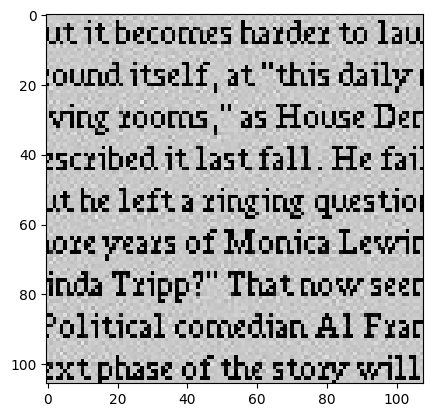

Look at from  350  to  395  on the x axis, and from  350  to  395  on the y axis to see this patch.


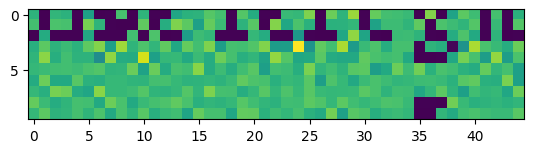

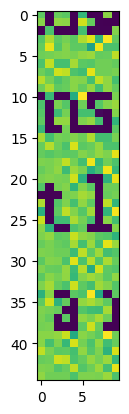

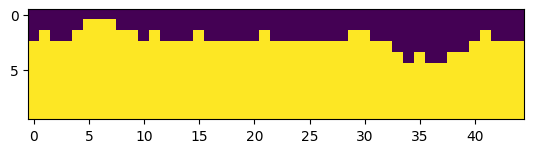

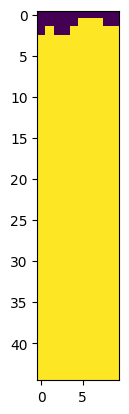

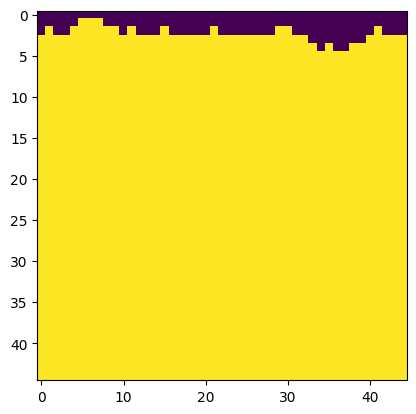

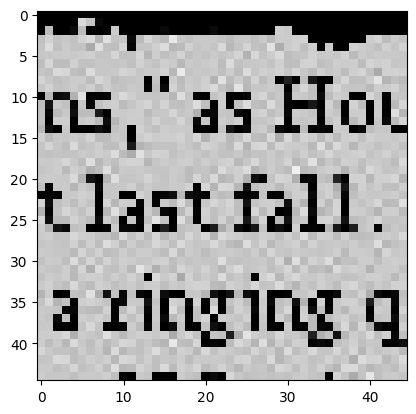

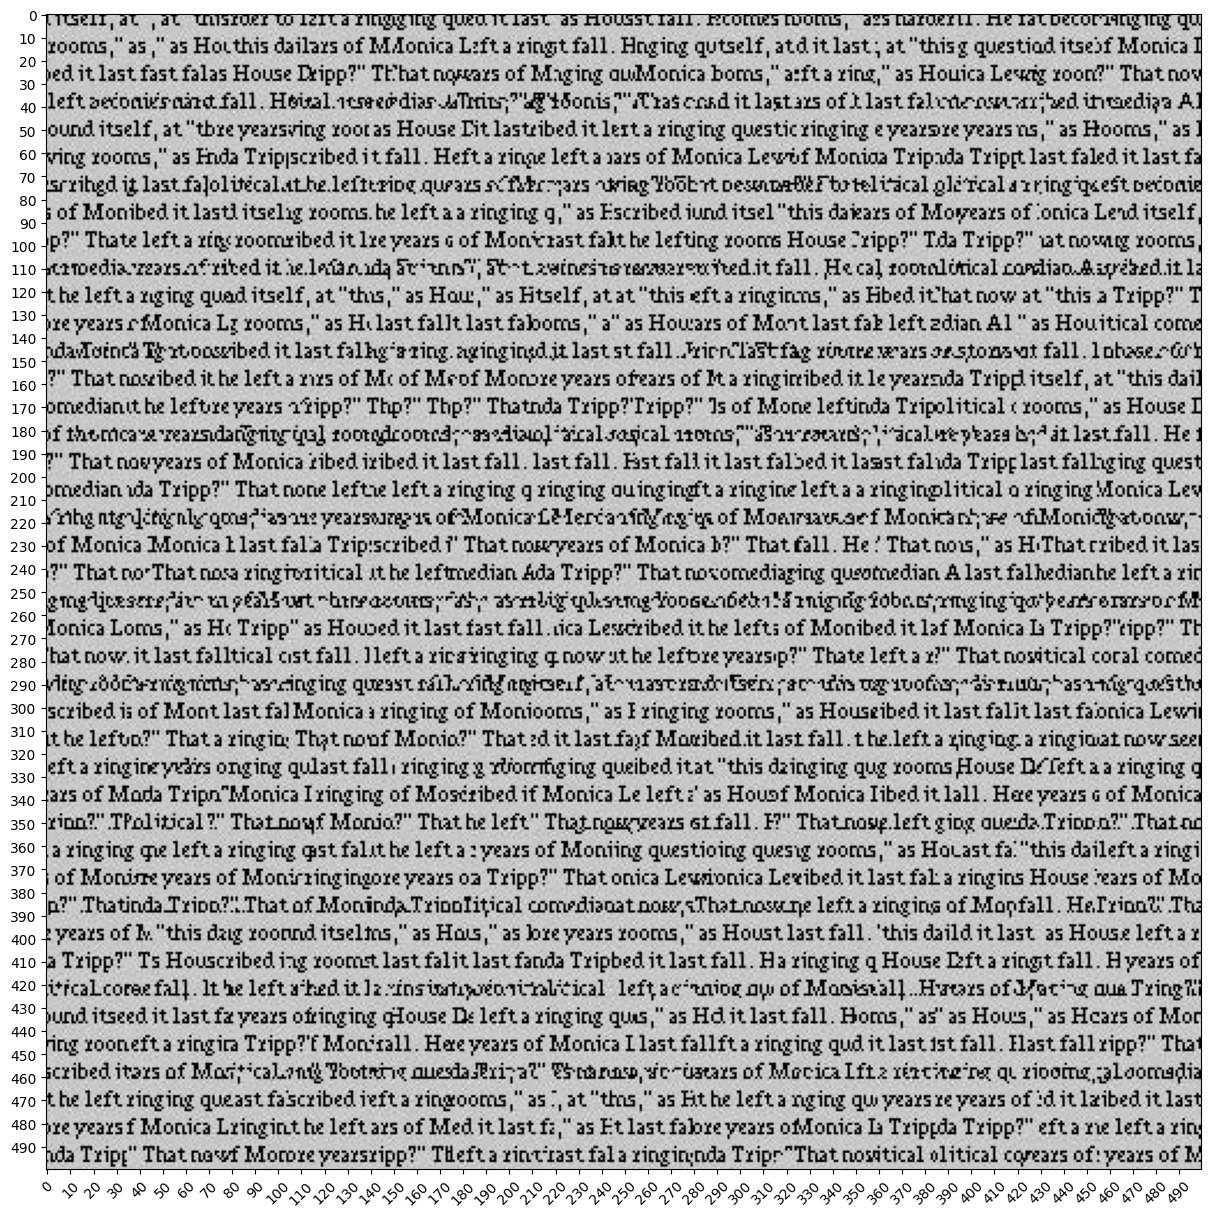

In [236]:
sample_img_fn = 'samples/text_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 500  # change these parameters as needed
patch_size = 45
overlap = 10
tol = 5

res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
res = res.astype(np.uint8)
if res is not None:
    plt.figure(figsize=(15, 15))
    plt.imshow(res)
    
    tick_freq = 10
    x_ticks = np.arange(0, res.shape[1], tick_freq)  # X-axis ticks
    y_ticks = np.arange(0, res.shape[0], tick_freq)  # Y-axis ticks
    
    plt.xticks(x_ticks, rotation=45)  # Rotate x-axis tick labels by 45 degrees
    plt.yticks(y_ticks)

### Part IV: Texture Transfer (30 pts)

In [189]:
# What is left to do?

# figure out what is going on with the cost.. just copy it from the working solution and implement changes needed to the choose_sample() to take this cost into account
# apply same methodology to other two if statements (left mask and both mask)

In [315]:
import math

def texture_transfer(sample_img, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray

    "The main difference between this function and quilt_cut is that there is an additional cost term based on the difference between the sampled source patch and the target patch at the location to be 
    filled."

    Goal: create a new image that combines two images, keeping the structure of the first but the textures of the second. 

    How will we do this? Put simply..
    """
    
    # basic idea: we just check SSD of where we are placing the patch, and the corresponding region in the texture image..
    
    guide_w, guide_h = guidance_im.shape[:2]

    top_mask = np.zeros((patch_size, patch_size, 3))
    left_mask = np.zeros((patch_size, patch_size, 3))
    both_mask = np.zeros((patch_size, patch_size, 3))

    top_mask[:overlap, :, :] = 1 
    left_mask[:,:overlap,:] = 1 
    both_mask[:, :overlap, :] = 1
    both_mask[:overlap, :, :] = 1

    black_image = np.zeros((guide_w, guide_h, 3))
    
    offset = patch_size - overlap 
    
    # Calculate the number of rows and columns, applying floor to the result
    rows = math.floor((guide_h - offset) / (offset))
    cols = math.floor((guide_w - offset) / (offset))

    for i in range(0, cols):
        for j in range(0, rows):
            # print(i,j)

            if i + j == 0:
                rand_row = random.randint(0, sample_img.shape[0]-patch_size)
                rand_col = random.randint(0, sample_img.shape[1]-patch_size)
                black_image[:patch_size, :patch_size, :] = sample_img[rand_row:rand_row+patch_size, rand_col:rand_col+patch_size, :].copy()
            elif j == 0:
                # set variables needed to get ssd's
                T = black_image[i * (patch_size - overlap):i * (patch_size - overlap) + patch_size, :patch_size, :] 
                M = top_mask
                I = sample_img
                target = guidance_im[i * (patch_size - overlap):i * (patch_size - overlap) + patch_size, :patch_size, :]

                # grab ssd's
                ssd = ssd_patch(T, M, I) 
                ssd_target = ssd_patch(target, M, I)

                # center
                h, w = ssd.shape                                                                                                                           
                ssd = ssd[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2] 
                h, w = ssd_target.shape                                                                                                                           
                ssd_target = ssd_target[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2]

                # alpha calculation
                ssd = ssd * alpha + ssd_target * (1 - alpha)
            
                (row, col) = choose_sample(ssd, tol) 
        
                new = sample_img[row:row+patch_size, col:col+patch_size,:].copy()

                if T.shape[:2] != (patch_size, patch_size) or new.shape[:2] != (patch_size, patch_size) or target.shape[:2] != (patch_size, patch_size):
                    continue
                
                overlapped_region = T[:overlap, :patch_size, :]**2 - new[:overlap, :patch_size, :]**2 
                
                overlapped_region = overlapped_region[:,:,0] + overlapped_region[:,:,1] + overlapped_region[:,:,2] 
                
                mask_path = cut(overlapped_region) 
                mask_path = mask_path.astype(np.uint8) 
        
                new[:overlap, :patch_size, 0] *= mask_path 
                new[:overlap, :patch_size, 1] *= mask_path
                new[:overlap, :patch_size, 2] *= mask_path
        
                inv_mask = np.ones(mask_path.shape) - mask_path
                T[:overlap, :patch_size, 0] *= inv_mask
                T[:overlap, :patch_size, 1] *= inv_mask
                T[:overlap, :patch_size, 2] *= inv_mask
                
                T += new

            elif i == 0:
                T = black_image[:patch_size, j * (patch_size - overlap):j * (patch_size - overlap) + patch_size, :] 
                M = left_mask
                I = sample_img
                target = guidance_im[:patch_size, j * (patch_size - overlap):j * (patch_size - overlap) + patch_size, :]

                ssd = ssd_patch(T, M, I) 
                ssd_target = ssd_patch(target, M, I)

                h, w = ssd.shape                                                                                                                           
                ssd = ssd[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2] 
                h, w = ssd_target.shape                                                                                                                           
                ssd_target = ssd_target[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2]
            
                ssd = ssd * alpha + ssd_target * (1 - alpha)
            
                (row, col) = choose_sample(ssd, tol) 
            
                new = sample_img[row:row+patch_size, col:col+patch_size,:].copy()

                if T.shape[:2] != (patch_size, patch_size) or new.shape[:2] != (patch_size, patch_size) or target.shape[:2] != (patch_size, patch_size):
                    continue
            
                overlapped_region = T[:patch_size, :overlap, :]**2 - new[:patch_size, :overlap, :]**2 
                overlapped_region = overlapped_region[:,:,0] + overlapped_region[:,:,1] + overlapped_region[:,:,2] 
            
                mask_path = cut(overlapped_region) 
                mask_path = mask_path.astype(np.uint8)
            
                new[:patch_size, :overlap, 0] *= mask_path 
                new[:patch_size, :overlap, 1] *= mask_path
                new[:patch_size, :overlap, 2] *= mask_path
            
                inv_mask = np.ones(mask_path.shape) - mask_path
                T[:patch_size, :overlap, 0] *= inv_mask
                T[:patch_size, :overlap, 1] *= inv_mask
                T[:patch_size, :overlap, 2] *= inv_mask    
            
                T += new
                
            else:
                T = black_image[i * (patch_size - overlap):i * (patch_size - overlap) + patch_size, 
                                j * (patch_size - overlap):j * (patch_size - overlap) + patch_size, :] 
                M = both_mask
                I = sample_img
                target = guidance_im[i * (patch_size - overlap):i * (patch_size - overlap) + patch_size, 
                                     j * (patch_size - overlap):j * (patch_size - overlap) + patch_size, :]
            
                ssd = ssd_patch(T, M, I) 
                ssd_target = ssd_patch(target, M, I)

                h, w = ssd.shape                                                                                                                           
                ssd = ssd[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2] 
                h, w = ssd_target.shape                                                                                                                           
                ssd_target = ssd_target[patch_size//2:h - patch_size//2, patch_size//2:w - patch_size//2]
            
                ssd = ssd * alpha + ssd_target * (1 - alpha)
            
                (row, col) = choose_sample(ssd, tol) 
            
                new = sample_img[row:row+patch_size, col:col+patch_size,:].copy()
                
                if T.shape[:2] != (patch_size, patch_size) or new.shape[:2] != (patch_size, patch_size) or target.shape[:2] != (patch_size, patch_size):
                    continue
            
                overlapped_region_above = T[:overlap, :patch_size, :]**2 - new[:overlap, :patch_size, :]**2
                overlapped_region_above = overlapped_region_above[:,:,0] + overlapped_region_above[:,:,1] + overlapped_region_above[:,:,2]
            
                overlapped_region_side = T[:patch_size, :overlap, :]**2 - new[:patch_size, :overlap, :]**2
                overlapped_region_side = overlapped_region_side[:,:,0] + overlapped_region_side[:,:,1] + overlapped_region_side[:,:,2]
            
                mask_path_above = cut(overlapped_region_above)
                mask_path_side = cut(overlapped_region_side)
            
                mask_path = np.ones((patch_size, patch_size))
                mask_path[:overlap, :patch_size] *= mask_path_above
                mask_path[:patch_size, :overlap] *= mask_path_side
                mask_path = mask_path.astype(np.uint8)
            
                new[:,:, 0] *= mask_path
                new[:,:, 1] *= mask_path
                new[:,:, 2] *= mask_path
            
                inv_mask = np.ones(mask_path.shape) - mask_path
                T[:,:, 0] *= inv_mask
                T[:,:, 1] *= inv_mask
                T[:,:, 2] *= inv_mask
            
                T += new
                
    return black_image


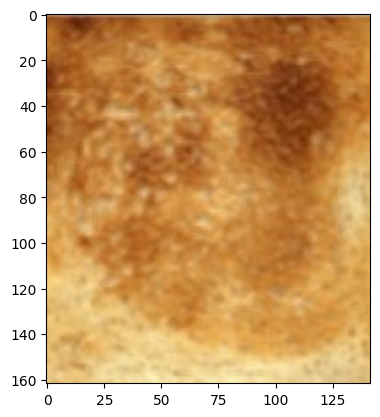

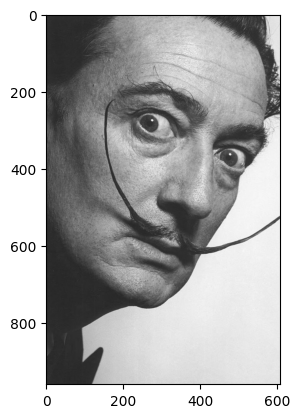

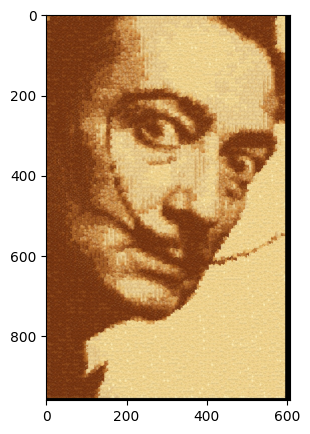

In [322]:
texture_img = 'samples/toast.jpg'
texture_img = cv2.cvtColor(cv2.imread(texture_img), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()

guidance_img = 'samples/Dali.jpg'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()

patch_size = 15
overlap = 5
tol = 30
alpha = 0.05
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)
res = res.astype(np.uint8)

plt.figure(figsize=(5,5))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).